In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# ***Data/Library Import***

In [ ]:
#library imports
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import re 
import spacy
import seaborn as sns
from collections import Counter
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import string
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from sklearn.metrics import mean_squared_error
import random
import math

In [ ]:
SEED = 1234
torch.manual_seed(SEED)
#loading the train data by using the "tab" or \t as a separator 
reviews = pd.read_csv("/content/drive/MyDrive/DL_Project_train.txt",sep="\t")
print(reviews.shape)
reviews.head(10)

(30160, 5)


,id,turn1,turn2,turn3,label
0,0,Don't worry I'm girl,hmm how do I know if you are,What's ur name?,others
1,1,When did I?,saw many times i think -_-,No. I never saw you,angry
2,2,By,by Google Chrome,Where you live,others
3,3,U r ridiculous,I might be ridiculous but I am telling the truth.,U little disgusting whore,angry
4,4,Just for time pass,wt do u do 4 a living then,Maybe,others
5,5,I'm a dog person,youre so rude,Whaaaat why,others
6,6,So whatsup,Nothing much. Sitting sipping and watching TV....,What are you watching on tv?,others
7,7,Ok,ok im back!!,"So, how are u",others
8,8,Really?,really really really really really,Y saying so many times...i can hear you,others
9,9,Bay,in the bay,😘 love you,others


In [ ]:
#concatination of turn 1, turn 2, turn 3 to create a single column of text
reviews['review'] = reviews['turn1'] + ' ' + reviews['turn2']+' '+reviews['turn3']

#resetting the dataframe index caused by data partitioning
reviews = reviews.sample(frac=1).reset_index(drop=True)
print(reviews.shape)

(30160, 6)


# ***DATA ANALYSIS***

In [ ]:
dataset=reviews

others    14948
angry      5506
sad        5463
happy      4243
Name: label, dtype: int64 

others    49.562334
angry     18.255968
sad       18.113395
happy     14.068302
Name: label, dtype: float64 



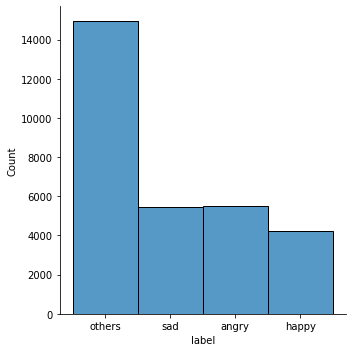

In [ ]:
#Visualization of the distribution on the train data
print(dataset['label'].value_counts() , '\n' )
#Counting Target Variable Distribution
print( (dataset['label'].value_counts()/len(dataset)) * 100 , '\n' )
#Counting Target Variable Distribution

sns.displot(dataset['label'])
#Seaborn Histogram Plot of Target Variable Distribution

In [ ]:
#getting all the total unique words count of all the turns (turn 1, turn 2, turn 3)
unique_words_all_turns=[]
temp_list=dataset['turn1'].append(dataset['turn2'].append(dataset['turn3'])) #appending every turn into the variable in order to access each turns.
#accessing the temp_list that contains the data for all turn and counts the total unique words.
for word in temp_list:
  temp = word.split(' ')
  for word in temp:
    if word not in unique_words_all_turns:
      unique_words_all_turns.append(word)
print('Unique word size for ALL TURNS:', len(unique_words_all_turns))
#prints out the total frequency of all the unique words
#word_count_value.append(len(unique_words_all_turns))

Unique word size for ALL TURNS: 33025


In [ ]:
#this function simply outputs the unique word count/size of turn 1
word_count_turns=[]
temp_list=dataset['turn1'] #assigning the turn 1 data into a variable
for word in temp_list: #the process on which every word is counted.
  temp = word.split(' ')
  for word in temp:
    if word not in word_count_turns:
      word_count_turns.append(word)
print('Unique word size for FIRST TURN:', len(word_count_turns)) #prints out the unique word count of turn 1
#word_count_value.append(len(word_count_turns))

Unique word size for FIRST TURN: 13146


In [ ]:
#this function simply outputs the unique word count/size of turn 2
word_count_turns=[]
temp_list=dataset['turn2']  #assigning the turn 2 data into a variable
for word in temp_list: #the process on which every word is counted.
  temp = word.split(' ')
  for word in temp:
    if word not in word_count_turns:
      word_count_turns.append(word)
print('Unique word size for SECOND TURN:', len(word_count_turns)) #prints out the unique word count of turn 2
#word_count_value.append(len(word_count_turns))

Unique word size for SECOND TURN: 19398


In [ ]:
#this function simply outputs the unique word count/size of turn 3
word_count_turns=[]
temp_list=dataset['turn3'] #assigning the turn 3 data into a variable
for word in temp_list: #the process on which every word is counted.
  temp = word.split(' ')
  for word in temp:
    if word not in word_count_turns:
      word_count_turns.append(word)
print('Unique word size for THIRD TURN:', len(word_count_turns)) #prints out the unique word count of turn 3
#word_count_value.append(len(word_count_turns))

Unique word size for THIRD TURN: 12778


In [ ]:
#shows the visualization and comparison of the word frequency of turn 1, turn 2, and turn 3.
import plotly as py
import plotly.graph_objects as go

data = [go.Bar(
            x = ['all','turn1','turn2','turn3'],
            y = word_count_value,
            marker = dict(colorscale = 'darkmint',
                         color = word_count_value
                         ),
            text = 'Word counts'
    )]

layout = go.Layout(
    title='Word Count Comparison (Turn 1, Turn 2, Turn 3)'
)

fig = go.Figure(data=data, layout = layout)
fig.show()

NameError: ignored

In [ ]:
# this funtion prints out and visualizes the top 10 unigrams for turn 1 (or the top 10 most used words in turn 1)
words = dataset['turn1'].str.split(expand = True).unstack().value_counts() #accessing the dataset turn 1 and assigning it into a variable

print(words.index.values[0:10],) #getting the top 10 words with the highest frequency
print(words.values[0:10]) #getting the actual value or frequency of the top 10 unigrams.

import plotly as py
import plotly.graph_objects as go

#visualizes the top unigrams in descending order (starting from the frequently used words down to less used word) together with the actual count of each word.
data = [go.Bar(
            x = words.index.values[0:10],
            y = words.values[0:10],
            marker = dict(colorscale = 'magma',
                         color = words.values[0:160]
                         ),
            text = 'Word counts'
    )]

layout = go.Layout(
    title='Top 10 Words (Turn 1)'
)

fig = go.Figure(data=data, layout = layout)
fig.show()

In [ ]:
# this funtion prints out and visualizes the top 10 unigrams for turn 2 (or the top 10 most used words in turn 2)
words = dataset['turn2'].str.split(expand = True).unstack().value_counts() #accessing the dataset turn 2 and assigning it into a variable


print(words.index.values[0:10],)#getting the top 10 words with the highest frequency
print(words.values[0:10]) #getting the actual value or frequency of the top 10 unigrams.

#visualizes the top unigrams in descending order (starting from the frequently used words down to less used word) together with the actual count of each word.
import plotly as py
import plotly.graph_objects as go

data = [go.Bar(
            x = words.index.values[0:10],
            y = words.values[0:10],
            marker = dict(colorscale = 'magenta',
                         color = words.values[0:160]
                         ),
            text = 'Word counts'
    )]

layout = go.Layout(
    title='Top 10 Words (Turn 2)'
)

fig = go.Figure(data=data, layout = layout)
fig.show()

In [ ]:
# this funtion prints out and visualizes the top 10 unigrams for turn 3 (or the top 10 most used words in turn 3)
words = dataset['turn3'].str.split(expand = True).unstack().value_counts() #accessing the dataset turn 3 and assigning it into a variable


print(words.index.values[0:10],) #getting the top 10 words with the highest frequency
print(words.values[0:10]) #getting the actual value or frequency of the top 10 unigrams.
#visualizes the top unigrams in descending order (starting from the frequently used words down to less used word) together with the actual count of each word.
import plotly as py
import plotly.graph_objects as go

data = [go.Bar(
            x = words.index.values[0:10],
            y = words.values[0:10],
            marker = dict(colorscale = 'rainbow',
                         color = words.values[0:160]
                         ),
            text = 'Word counts'
    )]

layout = go.Layout(
    title='Top 10 Words (Turn 3)'
)

fig = go.Figure(data=data, layout = layout)
fig.show()

In [ ]:
## this funtion prints out and visualizes the top 20 unigrams for all turns (or the top 20 most used words in all turns)
words = dataset['turn1'].append(dataset['turn2'].append(dataset['turn3'])).str.split(expand = True).unstack().value_counts() #accessing the dataset of all turns and assign it into a variable

print(words.index.values[0:20]) #getting the top 20 words with the highest frequency
print(words.values[0:20]) #getting the actual value or frequency of the top 20 unigrams.
#visualizes the top unigrams in descending order (starting from the frequently used words down to less used word) together with the actual count of each word.
import plotly as py
import plotly.graph_objects as go

data = [go.Bar(
            x = words.index.values[0:20],
            y = words.values[0:20],
            marker = dict(colorscale = 'darkmint',
                         color = words.values[0:160]
                         ),
            text = 'Word counts'
    )]

layout = go.Layout(
    title='Top 20 Words (All Turns)'
)

fig = go.Figure(data=data, layout = layout)
fig.show()


In [ ]:
#organizing the dataset depending on the label (happy, sad, angry, or others)
df = dataset.groupby('label') 
happy = df.get_group('happy')
sad = df.get_group('sad')
angry = df.get_group('angry')
others = df.get_group('others')

In [ ]:
#counts the overall data under the "Happy Class" in turn 1
value1=0
temp_list=happy['turn1']
for word in temp_list:
  value1+=1
print('Records for Happy Class:', value1)

In [ ]:
#counts the overall data under the "Sad Class" in turn 1
value2=0
temp_list=sad['turn1']
for word in temp_list:
  value2+=1
print('Records for Sad Class:', value2)

In [ ]:
#counts the overall data under the "Angry Class" in turn 1
value3=0
temp_list=angry['turn1']
for word in temp_list:
  value3+=1
print('Records for Angry Class:', value3)

In [ ]:
#counts the overall data under the "Others Class" in turn 1
value4=0
temp_list=others['turn1']
for word in temp_list:
  value4+=1
print('Records for Others Class:', value4)

In [ ]:
#function on getting the top 20 words in under the "Happy Class" on all turn (turn 1, turn 2, turn 3)
words = happy['turn1'].append(happy['turn2'].append(happy['turn3'])).str.split(expand = True).unstack().value_counts()#accessing all turns

print(words.index.values[0:20])#getting the top 20 words with the highest frequency
print(words.values[0:20]) #getting the actual value or frequency of the top 20 unigrams.

#visualizes the top unigrams in descending order (starting from the frequently used words down to less used word) together with the actual count of each word.
import plotly as py
import plotly.graph_objects as go

data = [go.Bar(
            x = words.index.values[0:20],
            y = words.values[0:20],
            marker = dict(colorscale = 'darkmint',
                         color = words.values[0:160]
                         ),
            text = 'Word counts'
    )]

layout = go.Layout(
    title='Top 20 Words on Happy Class (All Turns)'
)

fig = go.Figure(data=data, layout = layout)
fig.show()

In [ ]:
#function on getting the top 20 words in under the "Sad Class" on all turn (turn 1, turn 2, turn 3)
words = sad['turn1'].append(sad['turn2'].append(sad['turn3'])).str.split(expand = True).unstack().value_counts() #accessing all turns

print(words.index.values[0:20])#getting the top 20 words with the highest frequency
print(words.values[0:20]) #getting the actual value or frequency of the top 20 unigrams.

#visualizes the top unigrams in descending order (starting from the frequently used words down to less used word) together with the actual count of each word.

import plotly as py
import plotly.graph_objects as go

data = [go.Bar(
            x = words.index.values[0:20],
            y = words.values[0:20],
            marker = dict(colorscale = 'darkmint',
                         color = words.values[0:160]
                         ),
            text = 'Word counts'
    )]

layout = go.Layout(
    title='Top 20 Words on Sad Class (All Turns)'
)

fig = go.Figure(data=data, layout = layout)
fig.show()

In [ ]:
#function on getting the top 20 words in under the "Angry Class" on all turn (turn 1, turn 2, turn 3)
words = angry['turn1'].append(angry['turn2'].append(angry['turn3'])).str.split(expand = True).unstack().value_counts() #accessing all turns

print(words.index.values[0:20])#getting the top 20 words with the highest frequency
print(words.values[0:20]) #getting the actual value or frequency of the top 20 unigrams.

#visualizes the top unigrams in descending order (starting from the frequently used words down to less used word) together with the actual count of each word.
import plotly as py
import plotly.graph_objects as go

data = [go.Bar(
            x = words.index.values[0:20],
            y = words.values[0:20],
            marker = dict(colorscale = 'darkmint',
                         color = words.values[0:160]
                         ),
            text = 'Word counts'
    )]

layout = go.Layout(
    title='Top 20 Words on Angry Class (All Turns)'
)

fig = go.Figure(data=data, layout = layout)
fig.show()

In [ ]:
#function on getting the top 20 words in under the "Others Class" on all turn (turn 1, turn 2, turn 3)
words = others['turn1'].append(others['turn2'].append(others['turn3'])).str.split(expand = True).unstack().value_counts()#accessing all turns

print(words.index.values[0:20])#getting the top 20 words with the highest frequency
print(words.values[0:20]) #getting the actual value or frequency of the top 20 unigrams.

#visualizes the top unigrams in descending order (starting from the frequently used words down to less used word) together with the actual count of each word.

import plotly as py
import plotly.graph_objects as go

data = [go.Bar(
            x = words.index.values[0:20],
            y = words.values[0:20],
            marker = dict(colorscale = 'darkmint',
                         color = words.values[0:160]
                         ),
            text = 'Word counts'
    )]

layout = go.Layout(
    title='Top 20 Words on Others Class (All Turns)'
)

fig = go.Figure(data=data, layout = layout)
fig.show()


In [ ]:
#INSTALLING ADVERTOOLS - productivity and analysis tools used to analyze text and content
pip install advertools

In [ ]:
#Advertools is used to extract and analyze the emojis in the data
import advertools as adv
emoji_summary = adv.extract_emoji(dataset['turn1'].append(dataset['turn2'].append(dataset['turn3'])))
#List of dictionary keys such as ['emoji', 'emoji_text', 'emoji_flat', 'emoji_flat_text',
#'emoji_counts', 'emoji_freq', 'top_emoji', 'top_emoji_text', 'top_emoji_groups', 'top_emoji_sub_groups', 'overview']
#These keys are used to analyze the emojis in your data
emoji_summary.keys()
#Shows the distribution of all emojis in the data in a descending order (emoji, frequency) 
emoji_summary['top_emoji']

In [ ]:
#Overview of the emojis in the dataset
emoji_summary['overview']

In [ ]:
#Almost the same with 'top_emoji' but this time the emoji name is included (emoji, emoji name, frequency) and it is still in descending order
for emoji, text in (zip([x[0] for x in emoji_summary['top_emoji']], 
emoji_summary['top_emoji_text'], )):
  print(emoji,*text, sep=' ')

In [ ]:
#Visualization of the distribution of the top 20 emoji regardless of the emotion class, it shows the emoji name along with its frequency.
import matplotlib.pyplot as plt
fig, ax = plt.subplots(facecolor='#eeeeee')
fig.set_size_inches((9, 9))
ax.set_frame_on(False)
ax.barh([x[0] for x in emoji_summary['top_emoji_text'][:20]][::-1],
[x[1] for x in emoji_summary['top_emoji_text'][:20]][::-1])
ax.tick_params(labelsize=14)
ax.set_title('Top 20 Emoji', fontsize=18)
ax.grid()
fig.savefig(ax.get_title() + '.png', 
facecolor='#eeeeee',dpi=120,
bbox_inches='tight')
plt.show()

**Top Emojis Per Emotion Class**



In [ ]:
#Grouping the dataset according to each label/emotion class (Happy, Sad, Angry, and Others)
#In order to extract the top emojis per emotion class
df = dataset.groupby('label') 
happy = df.get_group('happy')
sad = df.get_group('sad')
angry = df.get_group('angry')
others = df.get_group('others')

In [ ]:
#Happy Emotion Class
print('Top Emojis (Happy Emotion Class)')
happy_summary = adv.extract_emoji(happy['turn1'].append(happy['turn2'].append(happy['turn3'])))
happy_summary['top_emoji']

In [ ]:
#Sad Emotion Class
print('Top Emojis (Sad Emotion Class)')
sad_summary = adv.extract_emoji(sad['turn1'].append(sad['turn2'].append(sad['turn3'])))
sad_summary['top_emoji']

In [ ]:
#Angry Emotion Class
print('Top Emojis (Angry Emotion Class)')
angry_summary = adv.extract_emoji(angry['turn1'].append(angry['turn2'].append(angry['turn3'])))
angry_summary['top_emoji']

In [ ]:
#Others Emotion Class
print('Top Emojis (Others)')
others_summary = adv.extract_emoji(others['turn1'].append(others['turn2'].append(others['turn3'])))
others_summary['top_emoji']

# ***DATA CLEANING METHODS***

In [ ]:
#DATA PRE-PROCESSING
import re
from textblob import TextBlob
from string import punctuation

#correcting some mispelled stop words suchs as u to you, r to are, and y to why
def correct_u_r_y(turn_text):
  temp=turn_text.split(" ")
  for i in range (0,len(temp)):
    temp[i]=re.sub('^[U]$','You',temp[i])
    temp[i]=re.sub('^[u]$','you',temp[i])
    temp[i]=re.sub('^[R]$','Are',temp[i])
    temp[i]=re.sub('^[r]$','are',temp[i])
    temp[i]=re.sub('^[Y]$','Why',temp[i]) 
    temp[i]=re.sub('^[y]$','why',temp[i])
    temp[i]=re.sub('^(Ur)$','Your',temp[i])
    temp[i]=re.sub('^(ur)$','your',temp[i])
    temp[i]=re.sub('^(UR)$','YOUR',temp[i])
    # temp[i] = temp[i].str.replace("\s{2,}", " ")
  filtered_sentence = (" ").join(temp)
  return filtered_sentence

#correcting all mispelled words using TextBlob
def correct_spelling(turn_text):
  temp=turn_text.split(" ")
  for i in range (0,len(temp)):
    textBlb = TextBlob(temp[i])            
    textCorrected = textBlb.correct()
    temp[i]=str(textCorrected)
  filtered_sentence = (" ").join(temp)
  return filtered_sentence

#replacing repeated close parenthesis into their single instances :))) -> :) )
def reduce_characters(turn_text):
  charList=set(punctuation)
  for i in charList:
    regex="(\\" +i+"\\"+i+"+)"
    turn_text=re.sub( regex, "\\"+i, turn_text)
  return turn_text

In [ ]:
#DOWNLOADING THE STOP WORDS using NLTK
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

stop = set(stopwords.words('english'))

#STOP WORDS REMOVAL - based on the list of stop words provided by NLTK
def stop_words_removal(turn_text):
  turn_text= turn_text.lower().split(" ")
  turn_text = [word for word in turn_text if word not in stop]
  filtered_sentence = (" ").join(turn_text)
  return filtered_sentence

#STEMMING - reducing the word to its root form
from nltk.stem.snowball import SnowballStemmer

def stemming_words(turn_text):
  stemmer = SnowballStemmer(language='english')
  turn_text= stemmer.stem(turn_text)
  return turn_text

In [ ]:
#DOWNLOADING WORDNET using NLTK - English lexical database
import nltk
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer 

#LOWER CASING STRINGS
def lower_case (turn_text):
  string = turn_text
  return string.lower()

#LEMMATIZATION - is like stemming but looks at the meaning of the word rather than the form of the word
def lemmatization(turn_text):
  lemmatizer = WordNetLemmatizer()
  return lemmatizer.lemmatize(turn_text)

In [ ]:
#All the data pre-processing methods are in a sequential order (depending on its use) combined into one function called 'cleaning'
def cleaning(turn):
  # turn=turn.apply(lambda x : [reduce_characters(item) for item in x])
  # print(1)
  turn=turn.apply(lambda x : [lower_case(item) for item in x])
  print(2)
  # turn=turn.apply(lambda x : [stemming_words(item) for item in x])
  # print(3)
  # turn=turn.apply(lambda x : [correct_u_r_y(item) for item in x])
  # print(4)
  # turn=turn.apply(lambda x : [correct_spelling(item) for item in x])
  # print(5)
  turn=turn.apply(lambda x : [stop_words_removal(item) for item in x])
  print(6)
  # turn=turn.apply(lambda x : [lemmatization(item) for item in x])
  # print(7)
  return turn

# ***RUN THIS TO CLEAN DATA, ELSE LEAVE ALONE***

In [ ]:
reviews['review']=cleaning(reviews['review'].to_frame())

# ***Create Dataset 1-3***

In [ ]:
others=reviews[reviews['label']=="others"]
happy=reviews[reviews['label']=="happy"]
angry=reviews[reviews['label']=="angry"]
sad=reviews[reviews['label']=="sad"]
print(len(others))

14948


In [ ]:
dataset1=pd.concat([happy,angry,sad,others[0:4982]])
dataset2=pd.concat([happy,angry,sad,others[4982:9964]])
dataset3=pd.concat([happy,angry,sad,others[9964:]])

dataset1.sample(frac=1).reset_index(drop=True)
dataset2.sample(frac=1).reset_index(drop=True)
dataset3.sample(frac=1).reset_index(drop=True)

,id,turn1,turn2,turn3,label,review
0,500,So sad,it's a sad sad situation,I am alone,sad,sad sad sad situation alone
1,674,Why??,Always you are judging me. :'( But I <3 you ra.,Wow lv u to??,happy,why?? always judging me. :'( <3 ra. wow lv u to??
2,23602,I don't like chocolate,WASTE?!?!?! I love chocolate sandwich! Ever tr...,I hate them... I hate you,angry,like chocolate waste?!?!?! love chocolate sand...
3,20182,OK dear really,You're welcome. 👍,I like it,happy,ok dear really welcome. 👍 like
4,7429,Are you dumb?,so as you,😠😠,angry,dumb? 😠😠
...,...,...,...,...,...,...
20191,24375,yes,ID DANCE AWAY FROM THEM,not dance sexy chat,others,yes id dance away dance sexy chat
20192,23760,In India or out of India,"Hi, Please refer to my answer to What are some...",AgrA,others,"india india hi, please refer answer travel des..."
20193,21905,Who is rude,I'm not being rude,Ok by,angry,rude i'm rude ok
20194,23450,Legends of tomorrow,best of luck for tomorrow,Riverdale,others,legends tomorrow best luck tomorrow riverdale


In [ ]:
print(len(dataset1[dataset1.label=="others"]))
print(len(dataset2[dataset2.label=="others"]))
print(len(dataset3[dataset3.label=="others"]))

4982
4982
4984


# ***SELECT WHICH DATASET TO USE***

In [ ]:
# reviews=dataset1
reviews=dataset2
# reviews=dataset3

# ***Data Partitioning and Pre-Processing***

In [ ]:
#getting the text (review) and the emotion label (rating)
reviews = reviews[['review', 'label']]
reviews.columns = ['review', 'rating']
# calculating sentence lengths
reviews['review_length'] = reviews['review'].apply(lambda x: len(x.split()))
reviews.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


,review,rating,review_length
1,today news whats good news 😂,happy,6
4,really get married get married. parents happy...,happy,10
17,street cat named bob meow... ;-) 😂,happy,7
18,u r sweetest <3 thanks sweet ☺ 😘😘😘,happy,8
30,dragon ball z dragon ball gt super,happy,7


In [ ]:
#convertion of the classes into numerical format
zero_numbering = {'happy':0, 'sad':1, 'angry':2,"others":3}
reviews['rating'] = reviews['rating'].apply(lambda x: zero_numbering[x])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
#mean sentence length
np.mean(reviews['review_length'])

7.5752624282036045

In [ ]:
#tokenization
tok = spacy.load('en')
def tokenize (text):
    return [token.text for token in tok.tokenizer(text)]

In [ ]:
#count number of occurences of each word
counts = Counter()
for index, row in reviews.iterrows():
    counts.update(tokenize(row['review']))

In [ ]:
#creating vocabulary
vocab2index = {"":0, "UNK":1}
words = ["", "UNK"]
for word in counts:
    vocab2index[word] = len(words)
    words.append(word)

In [ ]:
#sentence encoding where the creation of the vocab2index
#format Word:Number of Occurence i.e: You:100
#and word list is made
def encode_sentence(text, vocab2index, N=70):
    tokenized = tokenize(text)
    encoded = np.zeros(N, dtype=int)
    enc1 = np.array([vocab2index.get(word, vocab2index["UNK"]) for word in tokenized])
    length = min(N, len(enc1))
    encoded[:length] = enc1[:length]
    return encoded, length

In [ ]:
#application of the encode_sentence method
reviews['encoded'] = reviews['review'].apply(lambda x: np.array(encode_sentence(x,vocab2index )))
reviews.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,review,rating,review_length,encoded
1,today news whats good news 😂,0,6,"[[2, 3, 4, 5, 6, 3, 7, 0, 0, 0, 0, 0, 0, 0, 0,..."
4,really get married get married. parents happy...,0,10,"[[8, 9, 10, 11, 9, 10, 12, 13, 14, 14, 12, 15,..."
17,street cat named bob meow... ;-) 😂,0,7,"[[17, 18, 19, 20, 21, 22, 23, 7, 0, 0, 0, 0, 0..."
18,u r sweetest <3 thanks sweet ☺ 😘😘😘,0,8,"[[24, 25, 26, 27, 28, 29, 30, 31, 31, 31, 0, 0..."
30,dragon ball z dragon ball gt super,0,7,"[[32, 33, 34, 32, 33, 35, 36, 0, 0, 0, 0, 0, 0..."


In [ ]:
#Checking the data distribution for each class
Counter(reviews['rating'])

Counter({0: 4243, 1: 5463, 2: 5506, 3: 4984})

In [ ]:
#Splitting the Train and Validation Set to be used during processing
#Validation Set will consist of 20% of the data, and 80% for the Train Set
X = list(reviews['encoded'])
y = list(reviews['rating'])
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2)

# ***Pytorch Dataset***

In [ ]:
#Checking whether GPU exists, if it does, use GPU instead of default CPU
#for LSTM model processing
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
#Convertion of the Pandas Dataframe into a Pytorch Dataset
class ReviewsDataset(Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.y = Y
    
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        return torch.from_numpy(self.X[idx][0].astype(np.int32)).to(device), self.y[idx], self.X[idx][1]

In [ ]:
#Application of the Pytorch Dataset on the Pandas DataFrame format
train_ds = ReviewsDataset(X_train, y_train)
valid_ds = ReviewsDataset(X_valid, y_valid)

In [ ]:
#Creating 64 batches of the train and validation dataset
#using the DataLoader library
batch_size = 64
vocab_size = len(words)
train_dl = DataLoader(train_ds, batch_size=batch_size)
val_dl = DataLoader(valid_ds, batch_size=batch_size)

# ***LSTM with pretrained GloVe word embedding training***


In [ ]:
def train_model(model, epochs, lr,saving_path):
    parameters = filter(lambda p: p.requires_grad, model.parameters())
    #Utilization of Stochastic Gradient Descent for optimization
    #with corresponding Learning Rate
    best_valid_loss = float('inf')
    optimizer = torch.optim.SGD(parameters, lr=lr)
    best_epoch=0
    for i in range(epochs):
        sum_loss = 0.0
        total = 0
        correct=0.0
        for x, y, l in train_dl:
            # x is the data
            # y is the target variable (true label)
            # l is the label

            x = x.long()
            y = y.long().to(device)

            #prediction of the model using the given data
            y_pred = model(x, l)
            pred = torch.max(y_pred, 1)[1]

            #resetting gradients for each iteration
            optimizer.zero_grad()
            #using Cross Entropy for Loss calculation
            loss = F.cross_entropy(y_pred, y).to(device)
            #backward propagation
            loss.backward()
            #gradient step
            optimizer.step()
            #calculation of total loss value
            sum_loss += loss.item()*y.shape[0]
            total += y.shape[0]
            correct += (pred == y).float().sum()
        #return values from the validation metrics    
        val_loss, val_acc, val_rmse = validation_metrics(model, val_dl)

        #gathering the data for train loss, validation loss, accuracy
        #for each epoch
        train_loss.append(sum_loss/total)
        validation_loss.append(val_loss)
        accuracy_val.append(val_acc)

        print("Epoch "+str(i+1)+": train loss %.3f, val loss %.3f, train accuracy %.3f, val accuracy %.3f, and val rmse %.3f" % 
              (sum_loss/total, val_loss, correct/total, val_acc, val_rmse))
        
        if val_loss < best_valid_loss:
          best_valid_loss = val_loss
          best_val_acc=val_acc
          best_epoch=i
          torch.save({'epoch': i,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_loss': val_loss,
            'train_loss': sum_loss/total,
            'train_acc': correct/total,
            'val_acc':val_acc}
            , saving_path)
          

        if abs((sum_loss/total)-val_loss) >= 0.2:
          return best_epoch
    return best_epoch

def validation_metrics (model, valid_dl):
    correct = 0
    total = 0
    sum_loss = 0.0
    sum_rmse = 0.0
    for x, y, l in valid_dl:
      # x is the data
      # y is the target variable (true label)
      # l is the label
      x = x.long()
      y = y.long().to(device)

      #prediction of the model using the given data
      y_hat = model(x, l)

      #using Cross Entropy for Loss calculation
      loss = F.cross_entropy(y_hat, y).to(device)
      pred = torch.max(y_hat, 1)[1]

      #collecting the prediction data for y_pred use in classification report
      prediction.append(pred)

      #calculation of total loss value and RMSE
      correct += (pred == y).float().sum()
      total += y.shape[0]
      sum_loss += loss.item()*y.shape[0]
      sum_rmse += np.sqrt(mean_squared_error(pred.cpu(), y.cpu().unsqueeze(-1)))*y.shape[0]
    return sum_loss/total, correct/total, sum_rmse/total

In [ ]:
#Loading the 50-dimension GloVe Word Embedding file
def load_glove_vectors(glove_file):
    """Load the glove word vectors"""
    word_vectors = {}
    with open(glove_file) as f:
        for line in f:
            split = line.split()
            word_vectors[split[0]] = np.array([float(x) for x in split[1:]])
    return word_vectors

In [ ]:
#Creating a GloVe Word Embedding Matrix utilizing the vocab2index variable 
def get_emb_matrix(pretrained, word_counts,emb_size):
    """ Creates embedding matrix from word vectors"""
    vocab_size = len(word_counts) + 2
    vocab_to_idx = {}
    vocab = ["", "UNK"]
    W = np.zeros((vocab_size, emb_size), dtype="float32")
    W[0] = np.zeros(emb_size, dtype='float32') # adding a vector for padding
    W[1] = np.random.uniform(-0.25, 0.25, emb_size) # adding a vector for unknown words 
    vocab_to_idx["UNK"] = 1
    i = 2
    for word in word_counts:
        if word in word_vecs:
            W[i] = word_vecs[word]
        else:
            W[i] = np.random.uniform(-0.25,0.25, emb_size)
        vocab_to_idx[word] = i
        vocab.append(word)
        i += 1   
    return W, np.array(vocab), vocab_to_idx

# ***SELECT EMBEDDING DIMENSION. GloVe Dimension must match embed_size variable parameter***

In [ ]:
# embed options: 50, 100, 200, 300
path="/content/drive/MyDrive/GloVe/glove.6B.300d.txt"
embed_size=300

In [ ]:
#GloVe Embedding Process
word_vecs = load_glove_vectors(path)
pretrained_weights, vocab, vocab2index = get_emb_matrix(word_vecs, counts,embed_size)

In [ ]:
class LSTM_glove_vecs(torch.nn.Module) :
    def __init__(self, vocab_size, embedding_dim,num_layers, hidden_dim, dropout, glove_weights,bidirectional) :
        super().__init__()
        self.embeddings = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        #copying GloVe word embedding to model
        self.embeddings.weight.data.copy_(torch.from_numpy(glove_weights).to(device)) 
        self.embeddings.weight.requires_grad = False ## freeze embeddings
        #LSTM module
        self.lstm = nn.LSTM(embedding_dim, hidden_dim,num_layers, batch_first=True, bidirectional=bidirectional)
        #Linear module for the final prediction 
        #of which emotion class is the processed text
        self.linear = nn.Linear(hidden_dim, 4)
        #Dropout Regularization for LSTM
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x, l):
        x = self.embeddings(x)
        x = self.dropout(x)
        lstm_out, (ht, ct) = self.lstm(x)
        return self.linear(ht[-1])

# ***Experiment***

In [ ]:
#lists for collecting the loss, accuracy and y_pred
train_loss=list()
validation_loss=list()
accuracy_val=list()
prediction=list()

#h-params here
embedding=300
hidden_layers=300
num_layers=3
epoch=1000
dropout=0.1
bidirectional=True

#Loading the model with the GloVe Word Embedding and given parameters
model = LSTM_glove_vecs(vocab_size, 
                        embedding, 
                        num_layers, 
                        hidden_layers,
                        dropout, 
                        pretrained_weights,
                        bidirectional)
#Utilizing the GPU for the model
model.to(device)
#training the model 
stop_epoch=train_model(model, epochs=epoch, lr=0.001, saving_path='/content/drive/MyDrive/GloVe/raw_300d_lstm_d1.pt')

Epoch 1: train loss 1.386, val loss 1.386, train accuracy 0.248, val accuracy 0.242, and val rmse 1.801
Epoch 2: train loss 1.385, val loss 1.385, train accuracy 0.248, val accuracy 0.242, and val rmse 1.801
Epoch 3: train loss 1.384, val loss 1.384, train accuracy 0.248, val accuracy 0.244, and val rmse 1.795
Epoch 4: train loss 1.384, val loss 1.383, train accuracy 0.255, val accuracy 0.261, and val rmse 1.676
Epoch 5: train loss 1.383, val loss 1.383, train accuracy 0.279, val accuracy 0.280, and val rmse 1.367
Epoch 6: train loss 1.383, val loss 1.383, train accuracy 0.277, val accuracy 0.270, and val rmse 1.225
Epoch 7: train loss 1.382, val loss 1.382, train accuracy 0.273, val accuracy 0.264, and val rmse 1.213
Epoch 8: train loss 1.382, val loss 1.382, train accuracy 0.268, val accuracy 0.272, and val rmse 1.201
Epoch 9: train loss 1.382, val loss 1.382, train accuracy 0.273, val accuracy 0.273, and val rmse 1.207
Epoch 10: train loss 1.382, val loss 1.381, train accuracy 0.278

In [ ]:
print('Best model generated is at epoch: {0}'.format(stop_epoch+1))

Best model generated is at epoch: 1000


# ***Confusion Matrix***

In [ ]:
#Getting the y values (label)
targets=list()
for x,y,l in val_dl:
  for z in y:
    targets.append(z)

In [ ]:
preds=list()
#Getting the last 48 records of the prediction list 
#as the last 48 records contains the total 20% validation data prediction 
#which represents the y_pred generated
#by the prediction model
temp=prediction[(stop_epoch*64):(stop_epoch*64)+64]
for i in range (0,len(temp)):
  for z in temp[i]:
    preds.append(z.cpu().numpy())

In [ ]:
#Confusion Matrix
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
y_true = targets
y_pred = preds
print(confusion_matrix(y_true, y_pred))
print(classification_report(y_true, y_pred))

[[648  33  34 137]
 [ 34 793 109 161]
 [ 22  63 905 124]
 [ 85  74 133 685]]
              precision    recall  f1-score   support

           0       0.82      0.76      0.79       852
           1       0.82      0.72      0.77      1097
           2       0.77      0.81      0.79      1114
           3       0.62      0.70      0.66       977

    accuracy                           0.75      4040
   macro avg       0.76      0.75      0.75      4040
weighted avg       0.76      0.75      0.75      4040



# ***GRAPHS***

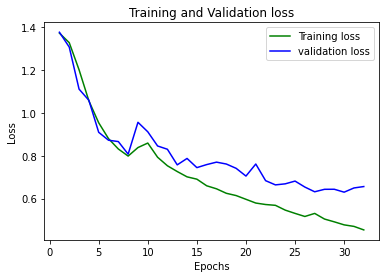

In [ ]:
#Train-Val Loss Graph
from matplotlib import pyplot as plt
import numpy as np

loss_train = train_loss
loss_val = validation_loss
epochs = range(1,len(train_loss)+1)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

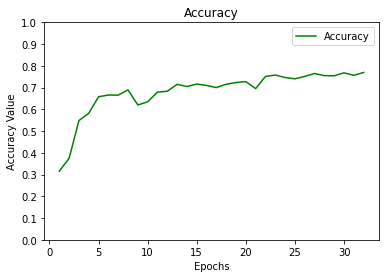

In [ ]:
#Accuracy
from matplotlib import pyplot as plt
import numpy as np

accuracy = accuracy_val
epochs = range(1, len(accuracy)+1)
plt.plot(epochs, accuracy, 'g', label='Accuracy')
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy Value')
plt.legend()
plt.show()

# ***Testing***